# Traffic Volume Prediction

### Import Statements

In [1]:
import pandas as pd                  # Pandas
from matplotlib import pyplot as plt # Matplotlib

import datetime as dt # Datetime

# Package to implement ML Algorithms
from sklearn.tree import DecisionTreeRegressor      # Decision Tree
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from sklearn.ensemble import AdaBoostRegressor      # Ada Boost
from xgboost import XGBRegressor   # XG Boost

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating classification report
from sklearn.metrics import classification_report

# Import packages to implement K-fold CV
from sklearn.model_selection import KFold # For creating folds

# Import Package to implement GridSearch CV
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

# Package to record time
import time

# Package for Data pretty printer
from pprint import pprint

# For metric comparison
from sklearn.model_selection import cross_val_score

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')


# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

### Data Import & Cleaning

In [2]:
# Import Data
traffic_df = pd.read_csv('Traffic_Volume.csv')
traffic_df.head()

# Summary of the data
traffic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [3]:
# Convert date_time column to datetime object
traffic_df['date_time'] = traffic_df['date_time'].apply(pd.to_datetime)

# Extract month, weekday, and hour
traffic_df['month'] = traffic_df['date_time'].dt.month
traffic_df['weekday'] = traffic_df['date_time'].dt.day_name()
traffic_df['hour'] = traffic_df['date_time'].dt.hour

In [4]:
# Dropping weather description and date_time column
traffic_df.drop(columns=['weather_description', 'date_time'], inplace = True)

In [5]:
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,5545,10,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,4516,10,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,4767,10,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,5026,10,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,4918,10,Tuesday,13


### Encoding & Preparing for Model Building

In [5]:
# Select input and output features
X = traffic_df.drop(columns = ['traffic_volume'])
y = traffic_df['traffic_volume']

# One hot encoding for categorical variables
cat_var = ['holiday', 'weather_main', 'month', 'weekday', 'hour']
X_encoded = pd.get_dummies(X, columns = cat_var)

In [6]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

# Creating folds
folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

### Model Building

#### Decision Tree

In [7]:
# Define your model
DTregressor = DecisionTreeRegressor(random_state = 42)

In [21]:
# Create the parameter grid based on the results of random search 
random_grid = {
    'max_depth': list(range(2, 40, 4)),
    'min_samples_leaf': list(range(5, 70, 5)),
    'min_samples_split': list(range(5, 70, 5))
}

pprint(random_grid)

# Call RandomizedSearchCV()
dt_model_cv = RandomizedSearchCV(estimator = DTregressor, 
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'r2', 
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

{'max_depth': [2, 6, 10, 14, 18, 22, 26, 30, 34, 38],
 'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65],
 'min_samples_split': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]}


In [22]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', dt_model_cv.best_score_)
print('Initial parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 10.734550952911377s
Initial score:  0.9368819169820779
Initial parameters:  {'min_samples_split': 55, 'min_samples_leaf': 5, 'max_depth': 30}


In [23]:
param_grid = {
    'max_depth': [20, 28, 30, 32, 40],
    'min_samples_leaf': [2, 5, 8, 12],
    'min_samples_split': [47, 53, 55, 57, 63]
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = DTregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [24]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', dt_model_cv.best_score_)
print('Improved parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 13.792605638504028s
Improved score:  0.9374845310427319
Improved parameters:  {'max_depth': 32, 'min_samples_leaf': 8, 'min_samples_split': 55}


In [8]:
param_grid = {
    'max_depth': [31, 32, 33, 34],
    'min_samples_leaf': [6, 7, 8, 9, 10],
    'min_samples_split': [54, 55, 56]
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = DTregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', dt_model_cv.best_score_)
print('Improved parameters: ', dt_model_cv.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Training time: 12.08892011642456s
Improved score:  0.9374863128759761
Improved parameters:  {'max_depth': 31, 'min_samples_leaf': 9, 'min_samples_split': 55}


In [9]:
# Storing best model
bestDT = dt_model_cv.best_estimator_

#### Random Forest

In [10]:
# Define your model
RFregressor = RandomForestRegressor(random_state = 42)

In [27]:
# Create the parameter grid based on the results of random search 
random_grid = {
    'n_estimators': list(range(60, 600, 80)),
    'max_depth': list(range(2, 44, 4)),
    'min_samples_leaf': list(range(2, 45, 5)),
    'min_samples_split': list(range(10, 75, 5))
}

pprint(random_grid)

# Call RandomizedSearchCV()
rf_model_cv = RandomizedSearchCV(estimator = RFregressor, 
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'r2', 
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

{'max_depth': [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42],
 'min_samples_leaf': [2, 7, 12, 17, 22, 27, 32, 37, 42],
 'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
 'n_estimators': [60, 140, 220, 300, 380, 460, 540]}


In [28]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', rf_model_cv.best_score_)
print('Initial parameters: ', rf_model_cv.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training time: 5229.006853580475s
Initial score:  0.9426641791572852
Initial parameters:  {'n_estimators': 380, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 34}


In [29]:
param_grid = {
    'max_depth': [31, 34, 37],
    'min_samples_leaf': [3, 7, 10],
    'min_samples_split': [6, 10, 14],
    'n_estimators': [150, 280, 410]
}

# Call GridSearchCV()
rf_model_cv = GridSearchCV(estimator = RFregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [30]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', rf_model_cv.best_score_)
print('Improved parameters: ', rf_model_cv.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Training time: 2990.74427652359s
Improved score:  0.9434135193273043
Improved parameters:  {'max_depth': 37, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 410}


In [35]:
param_grid = {
    'max_depth': [35, 37],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [6],
    'n_estimators': [200]
}

# Call GridSearchCV()
rf_model_cv = GridSearchCV(estimator = RFregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [36]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', rf_model_cv.best_score_)
print('Improved parameters: ', rf_model_cv.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Training time: 326.31423902511597s
Improved score:  0.943465981693748
Improved parameters:  {'max_depth': 37, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 400}


In [37]:
# CV results
cv_results = pd.DataFrame(rf_model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,154.506215,0.327681,1.593696,0.041200,35,3,6,400,"{'max_depth': 35, 'min_samples_leaf': 3, 'min_...",0.941795,0.947155,0.941288,0.943413,0.002654,4
1,146.651276,0.150439,1.761516,0.072825,35,4,6,400,"{'max_depth': 35, 'min_samples_leaf': 4, 'min_...",0.941504,0.947413,0.941456,0.943458,0.002797,2
2,155.043869,0.197563,1.603822,0.053609,37,3,6,400,"{'max_depth': 37, 'min_samples_leaf': 3, 'min_...",0.941805,0.947149,0.941288,0.943414,0.002650,3
3,147.373525,0.270197,1.720474,0.074259,37,4,6,400,"{'max_depth': 37, 'min_samples_leaf': 4, 'min_...",0.941522,0.947412,0.941464,0.943466,0.002790,1


In [11]:
param_grid = {
    'max_depth': [37],
    'min_samples_leaf': [4],
    'min_samples_split': [6],
    'n_estimators': [400]
}
# Call GridSearchCV()
rf_model_cv = GridSearchCV(estimator = RFregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [33]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', rf_model_cv.best_score_)
print('Improved parameters: ', rf_model_cv.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 279.754004240036s
Improved score:  0.943465981693748
Improved parameters:  {'max_depth': 37, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 400}


In [34]:
# Storing best model
bestRF = rf_model_cv.best_estimator_

Note: Github only takes files 100MB or smaller. So, using fewer trees (for a very marginal performance decrease) to fit file size requirement

In [12]:
param_grid = {
    'max_depth': [37],
    'min_samples_leaf': [4],
    'min_samples_split': [6],
    'n_estimators': [165]
}
# Call GridSearchCV()
rf_model_cv_small = GridSearchCV(estimator = RFregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [13]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv_small.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', rf_model_cv_small.best_score_)
print('Improved parameters: ', rf_model_cv_small.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 48.96940350532532s
Improved score:  0.9433840669759679
Improved parameters:  {'max_depth': 37, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 165}


In [14]:
# Storing best model
bestRF = rf_model_cv_small.best_estimator_

#### AdaBoost

In [15]:
# Define your model
Adaregressor = AdaBoostRegressor(random_state = 42)

In [94]:
# Create the parameter grid based on the results of random search 
random_grid = {
    'n_estimators': list(range(5, 150, 10)),
    'learning_rate': [round((0.80 + x/50), 2) for x in range(0, 11)]
}
print(random_grid)

{'n_estimators': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145], 'learning_rate': [0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]}


In [95]:
# Call RandomizedSearchCV()
ada_model_cv = RandomizedSearchCV(estimator = Adaregressor, 
                              param_distributions = random_grid,
                              n_iter = 50,
                              scoring = 'r2', 
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

In [96]:
# Fit the model
start = time.time()            # Start Time
ada_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', ada_model_cv.best_score_)
print('Initial parameters: ', ada_model_cv.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training time: 105.44202327728271s
Initial score:  0.38243349887387096
Initial parameters:  {'n_estimators': 5, 'learning_rate': 0.94}


In [97]:
# CV results
cv_results = pd.DataFrame(ada_model_cv.cv_results_)
cv_results.sort_values(by = 'rank_test_score').head(10)[['param_n_estimators', 'param_learning_rate', 'mean_test_score', 'mean_fit_time']]

,param_n_estimators,param_learning_rate,mean_test_score,mean_fit_time
17,5,0.94,0.382433,2.884881
15,5,0.84,0.376011,2.823284
20,5,0.9,0.348518,2.893334
32,5,0.88,0.347809,2.956979
36,5,0.86,0.343691,3.011383
0,5,0.98,0.330518,2.645878
12,5,0.82,0.315662,3.007711
47,75,0.82,0.264339,11.628545
40,115,0.82,0.264339,13.266005
5,145,0.82,0.264339,14.445682


In [17]:
param_grid = {
    'n_estimators': [2, 4, 5, 6, 10],
    'learning_rate': [0.93, 0.94, 0.95]
}
print(param_grid)

# Call GridSearchCV()
ada_model_cv = GridSearchCV(estimator = Adaregressor, 
                        param_grid = param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

{'n_estimators': [2, 4, 5, 6, 10], 'learning_rate': [0.93, 0.94, 0.95]}


In [18]:
# Fit the model
start = time.time()            # Start Time
ada_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Improved score: ', ada_model_cv.best_score_)
print('Improved parameters: ', ada_model_cv.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Training time: 9.466735601425171s
Improved score:  0.38243349887387096
Improved parameters:  {'learning_rate': 0.94, 'n_estimators': 5}


In [19]:
# Storing best model
bestADA = ada_model_cv.best_estimator_
bestADA

AdaBoostRegressor(learning_rate=0.94, n_estimators=5, random_state=42)

#### XGBoost

In [20]:
# Define the model
XGregressor = XGBRegressor(random_state = 42)

Begin tuning depth, child weight & gamma w/ initial randomized search

In [115]:
random_grid = {
    'max_depth': list(range(2,30,2)),
    'min_child_weight':list(range(1,30, 2)),
    'n_estimators': list(range(2, 150, 10))
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGregressor, 
                                param_distributions = random_grid, 
                                n_iter = 50,
                                scoring='r2',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28], 'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29], 'n_estimators': [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142]}


In [116]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 63.087974309921265s
Initial score:  0.947686744360147
Initial parameters:  {'n_estimators': 52, 'min_child_weight': 25, 'max_depth': 28}


In [117]:
# CV results
pd.DataFrame(xg_model_cv.cv_results_).sort_values(by = 'rank_test_score').head(10)[['param_max_depth', 'param_min_child_weight', 'param_n_estimators','mean_test_score', 'mean_fit_time']]

,param_max_depth,param_min_child_weight,param_n_estimators,mean_test_score,mean_fit_time
49,28,25,52,0.947687,0.951864
21,16,27,52,0.947682,0.760850
7,12,15,92,0.947668,0.862434
20,16,13,52,0.947463,0.977552
22,16,21,72,0.947422,1.013711
5,22,21,72,0.947307,1.159084
44,18,29,142,0.947249,1.594751
8,24,23,82,0.947232,1.401286
19,20,27,122,0.947098,1.843488
1,10,9,92,0.946837,0.835488


Continue tuning depth, child weight, n estimators & tune gamma & learning rate w/randomized search

In [118]:
random_grid = {
    'max_depth': list(range(12, 32, 2)),
    'min_child_weight':list(range(20, 38, 2)),
    'n_estimators': list(range(40, 95, 5)),
    'gamma': list(range(1,15)),    
    'learning_rate': [i/10.0 for i in range(1,11)]
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGregressor, 
                                param_distributions = random_grid, 
                                n_iter = 50,
                                scoring='r2',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [12, 14, 16, 18, 20, 22, 24, 26, 28, 30], 'min_child_weight': [20, 22, 24, 26, 28, 30, 32, 34, 36], 'n_estimators': [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90], 'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [119]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 41.4236900806427s
Initial score:  0.9488479368124866
Initial parameters:  {'n_estimators': 90, 'min_child_weight': 32, 'max_depth': 26, 'learning_rate': 0.1, 'gamma': 1}


In [122]:
pd.DataFrame(xg_model_cv.cv_results_).sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,1.409185,0.012996,0.107441,0.004287,90,32,26,0.1,1,"{'n_estimators': 90, 'min_child_weight': 32, '...",0.946748,0.953083,0.946713,0.948848,0.002995,1
11,1.061076,0.018559,0.082744,0.005179,65,20,22,0.2,5,"{'n_estimators': 65, 'min_child_weight': 20, '...",0.946748,0.952566,0.946763,0.948692,0.002739,2
33,0.979190,0.012568,0.081127,0.002119,55,32,28,0.2,4,"{'n_estimators': 55, 'min_child_weight': 32, '...",0.946671,0.952525,0.946710,0.948636,0.002751,3
35,1.250187,0.029091,0.095618,0.002940,85,20,22,0.2,2,"{'n_estimators': 85, 'min_child_weight': 20, '...",0.946692,0.952409,0.946786,0.948629,0.002673,4
43,0.964365,0.003941,0.084765,0.004390,90,34,18,0.2,13,"{'n_estimators': 90, 'min_child_weight': 34, '...",0.946462,0.952684,0.946732,0.948626,0.002872,5
29,1.151250,0.016275,0.084535,0.006111,75,28,22,0.1,13,"{'n_estimators': 75, 'min_child_weight': 28, '...",0.946698,0.952838,0.946341,0.948626,0.002982,6
20,1.297095,0.001546,0.094051,0.001124,65,24,30,0.2,14,"{'n_estimators': 65, 'min_child_weight': 24, '...",0.947031,0.952140,0.946515,0.948562,0.002539,7
47,1.017562,0.020881,0.076448,0.002804,60,24,24,0.2,12,"{'n_estimators': 60, 'min_child_weight': 24, '...",0.946936,0.951974,0.946519,0.948476,0.002479,8
49,1.296758,0.037548,0.085810,0.010350,80,34,28,0.1,9,"{'n_estimators': 80, 'min_child_weight': 34, '...",0.946396,0.952676,0.946253,0.948442,0.002995,9
23,1.382335,0.017222,0.102435,0.003935,80,26,28,0.2,14,"{'n_estimators': 80, 'min_child_weight': 26, '...",0.946493,0.951523,0.946577,0.948198,0.002351,10


Initial score:  0.9483948367745022
Initial parameters:  {'n_estimators': 82, 'min_child_weight': 29, 'max_depth': 16, 'learning_rate': 0.2, 'gamma': 7}

Continue tuning main hyperparameters & tune tree specific parameters w/randomized search

In [111]:
random_grid = {
    'max_depth': list(range(18, 30, 2)),
    'min_child_weight':list(range(15, 35, 4)),
    'gamma': list(range(1, 10, 2)),
    'n_estimators': list(range(60, 120, 10)),
    'learning_rate': [i/20.0 for i in range(1,11)],
    'subsample':[(0.5 + i/20.0) for i in range(1,11)],
    'colsample_bytree':[(0.5 + i/20.0) for i in range(1,11)]
}

print(random_grid)

xg_model_cv = RandomizedSearchCV(estimator = XGregressor, 
                                param_distributions = random_grid, 
                                n_iter = 100,
                                scoring='r2',
                                n_jobs=4,
                                cv=folds, 
                                random_state = 42)

{'max_depth': [12, 14, 16, 18, 20, 22], 'min_child_weight': [27, 29, 31, 33, 35, 37, 39], 'gamma': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'n_estimators': [80, 90, 100, 110, 120, 130], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], 'subsample': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 'colsample_bytree': [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}


In [123]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Training time: 48.94174838066101s
Initial score:  0.9488479368124866
Initial parameters:  {'n_estimators': 90, 'min_child_weight': 32, 'max_depth': 26, 'learning_rate': 0.1, 'gamma': 1}


Initial score:  0.949037800874924
Initial parameters:  {'subsample': 0.85, 'n_estimators': 100, 'min_child_weight': 29, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 10, 'colsample_bytree': 0.9}

In [113]:
pd.DataFrame(xg_model_cv.cv_results_).sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
31,1.325626,0.005024,0.096174,0.005502,0.85,100,29,20,0.1,10,0.9,"{'subsample': 0.85, 'n_estimators': 100, 'min_...",0.946564,0.953553,0.946996,0.949038,0.003198,1
10,1.437167,0.013841,0.108787,0.002905,0.8,110,31,20,0.1,4,1.0,"{'subsample': 0.8, 'n_estimators': 110, 'min_c...",0.946490,0.953012,0.947038,0.948846,0.002954,2
42,0.953672,0.020634,0.077302,0.001707,0.95,80,39,18,0.2,10,1.0,"{'subsample': 0.95, 'n_estimators': 80, 'min_c...",0.946411,0.952494,0.946290,0.948398,0.002896,3
54,0.876337,0.008810,0.072790,0.000604,0.95,80,35,16,0.15,8,0.9,"{'subsample': 0.95, 'n_estimators': 80, 'min_c...",0.946083,0.952547,0.946303,0.948311,0.002997,4
3,1.296533,0.010925,0.094280,0.003191,0.7,100,31,20,0.1,11,0.85,"{'subsample': 0.7, 'n_estimators': 100, 'min_c...",0.945331,0.952732,0.946580,0.948214,0.003235,5
64,1.303801,0.004267,0.103629,0.003400,0.8,130,37,16,0.15,5,1.0,"{'subsample': 0.8, 'n_estimators': 130, 'min_c...",0.946037,0.952632,0.945662,0.948110,0.003201,6
63,0.976340,0.011967,0.077002,0.004056,0.8,80,31,18,0.1,7,0.95,"{'subsample': 0.8, 'n_estimators': 80, 'min_ch...",0.945481,0.952658,0.946091,0.948077,0.003249,7
55,1.614689,0.012198,0.114228,0.000914,0.8,130,31,20,0.2,4,0.9,"{'subsample': 0.8, 'n_estimators': 130, 'min_c...",0.946140,0.951931,0.946113,0.948062,0.002736,8
26,1.184099,0.011403,0.096108,0.003939,0.85,110,37,18,0.15,13,0.7,"{'subsample': 0.85, 'n_estimators': 110, 'min_...",0.945407,0.951983,0.945750,0.947713,0.003022,9
1,1.221475,0.088194,0.093883,0.005198,0.75,100,31,18,0.25,12,0.95,"{'subsample': 0.75, 'n_estimators': 100, 'min_...",0.946025,0.951319,0.945650,0.947665,0.002589,10


Gridsearch tuning for best hyperparameters

In [ ]:
{'subsample': 0.85, 'n_estimators': 100, 'min_child_weight': 29, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 10, 'colsample_bytree': 0.9}

In [126]:
param_grid = {
    'max_depth': [18, 20, 22],
    'min_child_weight':[26, 30, 34],
    'gamma': [7, 10, 13],
    'n_estimators': [90, 100],
    'learning_rate': [0.07, 0.1, 0.13],
    'subsample':[0.85, 0.89],
    'colsample_bytree':[0.87, 0.90, 0.93]
}
print(param_grid)

xg_model_cv = GridSearchCV(estimator = XGregressor, 
                            param_grid = param_grid, 
                            scoring='r2',
                            cv=folds, 
                            verbose = 1,
                            n_jobs=-1)

{'max_depth': [18, 20, 22], 'min_child_weight': [26, 30, 34], 'gamma': [7, 10, 13], 'n_estimators': [90, 100], 'learning_rate': [0.07, 0.1, 0.13], 'subsample': [0.85, 0.89], 'colsample_bytree': [0.87, 0.9, 0.93]}


In [127]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Training time: 1046.9031400680542s
Initial score:  0.9495745275927788
Initial parameters:  {'colsample_bytree': 0.93, 'gamma': 7, 'learning_rate': 0.1, 'max_depth': 22, 'min_child_weight': 30, 'n_estimators': 100, 'subsample': 0.89}


In [21]:
param_grid = {
    'max_depth': [22, 24],
    'min_child_weight':[30],
    'gamma': [5, 7],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample':[0.89, 0.91],
    'colsample_bytree':[0.93, 0.95]
}
print(param_grid)

xg_model_cv = GridSearchCV(estimator = XGregressor, 
                            param_grid = param_grid, 
                            scoring='r2',
                            cv=folds, 
                            verbose = 1,
                            n_jobs=-1)

{'max_depth': [22, 24], 'min_child_weight': [30], 'gamma': [5, 7], 'n_estimators': [100], 'learning_rate': [0.1], 'subsample': [0.89, 0.91], 'colsample_bytree': [0.93, 0.95]}


In [22]:
# Fit the model
start = time.time()            # Start Time
xg_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time

# Print Results
print(f"Training time: {stop - start}s")
print('Initial score: ', xg_model_cv.best_score_)
print('Initial parameters: ', xg_model_cv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Training time: 13.042128562927246s
Initial score:  0.9496631773608467
Initial parameters:  {'colsample_bytree': 0.95, 'gamma': 7, 'learning_rate': 0.1, 'max_depth': 22, 'min_child_weight': 30, 'n_estimators': 100, 'subsample': 0.91}


In [23]:
bestXG = xg_model_cv.best_estimator_

Sources Used:
- https://datascience.stackexchange.com/questions/74488/tuning-parameters-for-gradient-boosting-xgboost
- https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Comparing Model Test Metrics

In [151]:
# create function to calculate cross validated metrics
def regressionMetrics(model):
    rmse = abs(cross_val_score(model, test_X, test_y, scoring='neg_root_mean_squared_error', cv=folds).mean())
    r2 = cross_val_score(model, test_X, test_y, scoring='r2', cv=folds).mean()

    return r2, rmse

In [157]:
# calculate CV metrics for each model
dt_r2, dt_rmse = regressionMetrics(bestDT)
rf_r2, rf_rmse = regressionMetrics(bestRFsmall)
ada_r2, ada_rmse = regressionMetrics(bestADA)
xg_r2, xg_rmse = regressionMetrics(bestXG)


In [206]:
# create dataframe to display metric comparison
metrics = [['Decision Tree', dt_r2, dt_rmse],
           ['Random Forest', rf_r2, rf_rmse],
           ['Ada Boost', ada_r2, ada_rmse],
           ['XG Boost', xg_r2, xg_rmse]]
cols = ['ML Model', 'R2', 'RMSE']
metric_df = pd.DataFrame(data = metrics, columns = cols)

In [207]:
metric_df.to_csv('model_comparison.csv') 

### Feature Importance

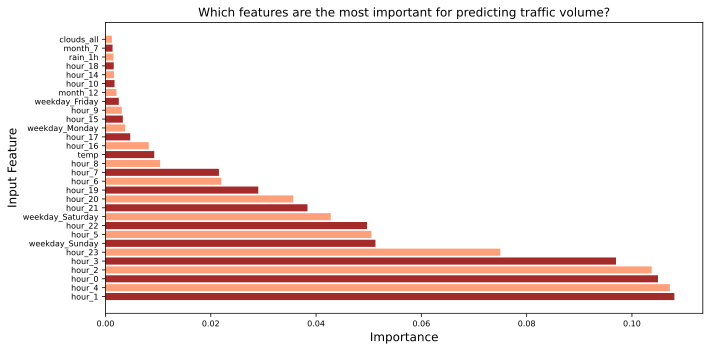

In [44]:
# Decision Tree Feature Importance
# Storing importance values from the trained model
importance = dt_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig1 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig1.savefig("dt_feature_imp.svg", bbox_inches='tight')

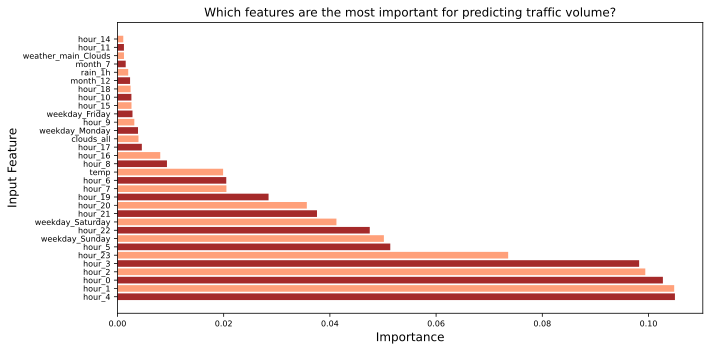

In [61]:
# Random Forest Feature Importance
# Storing importance values from the trained model
importance = rf_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig2 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig2.savefig("rf_feature_imp.svg", bbox_inches='tight')

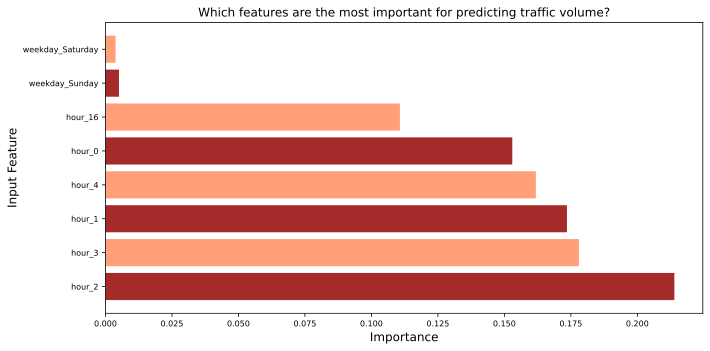

In [35]:
# Ada Boost Feature Importance
# Storing importance values from the trained model
importance = ada_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig3 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig3.savefig("ada_feature_imp.svg", bbox_inches='tight')

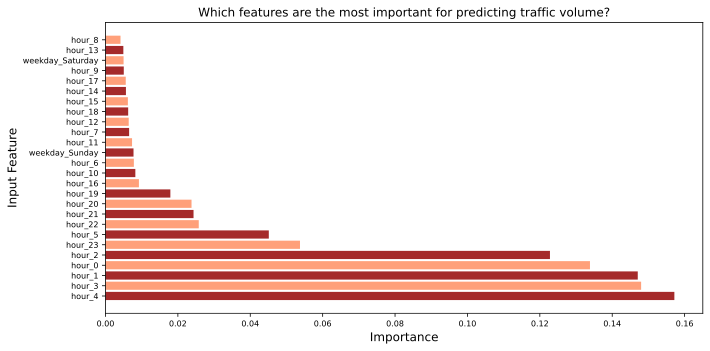

In [213]:
# XG Boost Feature Importance
# Storing importance values from the trained model
importance = xg_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])
feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Selecting features with non-zero importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.001]

# Bar plot
fig4 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color = ['brown', 'lightsalmon'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

fig4.savefig("xg_feature_imp.svg", bbox_inches='tight')

### Pickling

In [24]:
# Creating the file where we want to write the model
dt_pickle = open('dt_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(bestDT, dt_pickle)

# Close the file
dt_pickle.close() 

In [25]:
# Creating the file where we want to write the model
rf_pickle = open('rf_traffic.pickle', 'wb') 

# Write RF model to the file
pickle.dump(bestRF, rf_pickle) 

# Close the file
rf_pickle.close() 

In [26]:
# Creating the file where we want to write the model
ada_pickle = open('ada_traffic.pickle', 'wb') 

# Write AdaBoost model to the file
pickle.dump(bestADA, ada_pickle) 

# Close the file
ada_pickle.close() 

In [27]:
# Creating the file where we want to write the model
xg_pickle = open('xg_traffic.pickle', 'wb') 

# Write XGBoost model to the file
pickle.dump(bestXG, xg_pickle) 

# Close the file
xg_pickle.close() 